In [1]:
import os
import math
import torch
import pickle
import pydicom
import numpy as np
import ThickSimulation as ts
from tqdm import tqdm
import SimpleITK as sitk
import matplotlib.pyplot as plt
from skimage.metrics import mean_squared_error as mse
from skimage.metrics import normalized_root_mse as nrmse
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

In [2]:
data_dir = '../AAPM_Mayo/Patient_Data'

# Thickenning

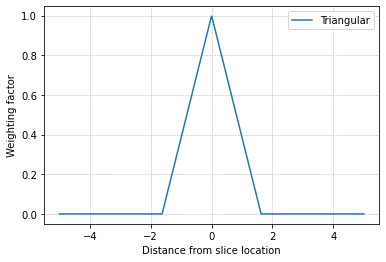

In [3]:
# Display the shape of the window

# Define the slice location, sample location, and slice thickness
slice_location = 0.0
sample_location = 0.0
slice_thickness = 1.0
# Define the x-values for the plot
x = np.linspace(-5*slice_thickness, 5*slice_thickness, 1000)

# Evaluate the triangular and Gaussian window functions at each x-value
triangular_y = [ts.InverseTriangleWindow(slice_location, xi, slice_thickness) for xi in x]
gaussian_y = [ts.GaussianWindow(slice_location, xi, slice_thickness) for xi in x]

# Plot the triangular and Gaussian window functions
plt.plot(x, triangular_y, label='Triangular')
#plt.plot(x, gaussian_y, label='Gaussian')

# Add a legend and axis labels
plt.legend()
plt.xlabel('Distance from slice location')
plt.ylabel('Weighting factor')
plt.grid(linestyle = '--', linewidth = 0.5)
# Show the plot
plt.show()

# Read the file

In [4]:
B30_path = []
D45_path = []
for subject_dir in tqdm(sorted(os.listdir(data_dir)), total=len(os.listdir(data_dir))):
    subject_dir_path = os.path.join(data_dir, subject_dir)
    if not os.path.isdir(subject_dir_path):
        continue
    for kernel_dir in os.listdir(subject_dir_path):
        if 'B30' in kernel_dir:
            B30_path.append(os.path.join(subject_dir_path,kernel_dir))
        if 'D45' in kernel_dir:
            D45_path.append(os.path.join(subject_dir_path,kernel_dir))
B30_path.sort()
D45_path.sort()

100%|██████████| 3/3 [00:00<00:00, 6192.38it/s]


In [5]:
print(B30_path)
print(D45_path)

['../AAPM_Mayo/Patient_Data/Testing_Image_Data/1mm B30', '../AAPM_Mayo/Patient_Data/Testing_Image_Data/3mm B30', '../AAPM_Mayo/Patient_Data/Training_Image_Data/1mm B30', '../AAPM_Mayo/Patient_Data/Training_Image_Data/3mm B30']
['../AAPM_Mayo/Patient_Data/Testing_Image_Data/1mm D45', '../AAPM_Mayo/Patient_Data/Testing_Image_Data/3mm D45', '../AAPM_Mayo/Patient_Data/Training_Image_Data/1mm D45', '../AAPM_Mayo/Patient_Data/Training_Image_Data/3mm D45']


In [ ]:
# Simulate Thick Slice for kernel D45 and B30
direct_upsample = False # Set to True if you want to up-sample the thick-slice to the same dimension as thin-slice
inverse_weighting = False # Set to True if you want to up-sample using inverse-weighting, else nn.functional.interpolate
for kernel_dir in B30_path:  
    if not '1mm' in kernel_dir:# only do the downsampling average on 1mm
        continue
    for dose_dir in os.listdir(kernel_dir):
        if 'f' in dose_dir.lower():
            dose_dir = os.path.join(kernel_dir,dose_dir)
            for case_dir in os.listdir(dose_dir): # only read 1 case for testing
                case_dir = os.path.join(dose_dir, case_dir)
                for repeat_dir in os.listdir(case_dir):
                    case_dir = os.path.join(case_dir, repeat_dir)
                    print(f"Retrieving thin images from: {case_dir}")             
                    dicom_files = [pydicom.dcmread(os.path.join(case_dir,file_name)) for file_name in os.listdir(case_dir) if file_name.endswith('.IMA')]
                    if len(dicom_files) > 0:
                        dicom_files.sort(key=lambda x: float(x.ImagePositionPatient[2]))
                        ReconVolume = ts.generate_config(dicom_files)
                        
                        if direct_upsample and inverse_weighting:
                            print('-'*31)
                            print('Now perform the inverse-weighted up-sampling for inference')
                            ReconVolume['SliceThickness'] = dicom_files[0].SliceThickness
                            ReconVolume['SliceSpacing'] = abs(float(dicom_files[1].ImagePositionPatient[2]) - float(dicom_files[0].ImagePositionPatient[2]))
                            thick_case_dir = case_dir.replace('1mm', '3mm')                         
                            thick_dicom_files = [pydicom.dcmread(os.path.join(thick_case_dir,file_name)) for file_name in os.listdir(thick_case_dir) if file_name.endswith('.IMA')]
                            upsampled_thick = Thickness(ReconVolume, thick_dicom_files,'IU',is_dicom=True)
                            assert len(upsampled_thick) == len(dicom_files), f"Upsampled size doesn't match"
                            thick_images_array = np.zeros((len(upsampled_thick),512,512))
                            for i in range(len(upsampled_thick)):
                                thick_images_array[i,:,:] = upsampled_thick[i].Data
                                
                        elif direct_upsample and not inverse_weighting:
# ------------------------------------------------------------------------------------------------
                            print('now perform interpolated up-sampling')
                            thick_case_dir = case_dir.replace('1mm', '3mm')                         
                            thick_dicom_files = [pydicom.dcmread(os.path.join(thick_case_dir,file_name)) for file_name in os.listdir(thick_case_dir) if file_name.endswith('.IMA')]
                            thick_dicom_files.sort(key=lambda x: float(x.ImagePositionPatient[2]))
                            thick_images = np.zeros((len(thick_dicom_files),512,512))
                            for i in range(len(thick_dicom_files)):
                                thick_images[i,:,:] = thick_dicom_files[i].pixel_array
                            thick_images_array = torch.nn.functional.interpolate(torch.unsqueeze(torch.unsqueeze(torch.from_numpy(thick_images).to(torch.float32),0),0),
                                                  size=(len(dicom_files),512,512),
                                                  mode='trilinear')[0,0,:,:,:]
                        else:
                            thick_images = ts.Thickness(ReconVolume, dicom_files,'T')
                            thick_images_array = np.zeros((len(thick_images),512,512))
                            for i in range(len(thick_images)):
                                thick_images_array[i,:,:] = thick_images[i].Data
                            thick_case_dir = case_dir.replace('1mm', '3mm')                         
                            thick_dicom_files = [pydicom.dcmread(os.path.join(thick_case_dir,file_name)) for file_name in os.listdir(thick_case_dir) if file_name.endswith('.IMA')]
                            thick_dicom_files.sort(key=lambda x: float(x.ImagePositionPatient[2]))
                            if thick_images_array.shape[0] != len(thick_dicom_files):
                                print('fix dimension here')
                                thick_images_array = torch.nn.functional.interpolate(torch.unsqueeze(torch.unsqueeze(torch.from_numpy(thick_images_array).to(torch.float32),0),0),
                                                  size=(len(thick_dicom_files),512,512),
                                                  mode='trilinear')[0,0,:,:,:].numpy()
                        # Save the Thick-Slice Image
                        save_filename = "thick_images.pickle"
                        save_path = os.path.join(case_dir, save_filename)
                        print(f"Thick-slice saved at: {save_path}")
                        with open(save_path, "wb") as file:
                            pickle.dump(thick_images_array, file)

# Naïve Averaging Thickenning

In [15]:
# Simulate Thick Slice in a naïve way
for kernel_dir in B30_path:#Specify the kernel folder here 
    if not '1mm' in kernel_dir:# only do the downsampling average on 1mm
        continue
    for dose_dir in os.listdir(kernel_dir):
        if 'f' in dose_dir.lower():
            dose_dir = os.path.join(kernel_dir,dose_dir)
            for case_dir in os.listdir(dose_dir): # only read 1 case for testing
                case_dir = os.path.join(dose_dir, case_dir)
                for repeat_dir in os.listdir(case_dir):
                    case_dir = os.path.join(case_dir, repeat_dir)
                    #case_dir = case_dir.replace('1mm', '3mm')
                    print(f"Retrieving thin images from: {case_dir}")             
                    dicom_files = [pydicom.dcmread(os.path.join(case_dir,file_name)) for file_name in os.listdir(case_dir) if file_name.endswith('.IMA')]
                    if len(dicom_files) > 0:
                        dicom_files.sort(key=lambda x: float(x.ImagePositionPatient[2]))
                        
                        temp_images = ts.average_thickness(dicom_files,3)
                        #temp_images = ts.Gaussian_average_thickness(dicom_files,3,1.0)
                        #temp_images = ts.downsampling_thickness(dicom_files,3)
                        
                        temp_images = torch.unsqueeze(torch.unsqueeze(torch.from_numpy(temp_images),0),0)
                        # Switching to groundtruth thick dir
                        thick_case_dir = case_dir.replace('1mm', '3mm') 
                        print(f"Retrieving true thick images from: {thick_case_dir}")
                        dicom_files = [pydicom.dcmread(os.path.join(thick_case_dir,file_name)) for file_name in os.listdir(thick_case_dir) if file_name.endswith('.IMA')]
                        dicom_files.sort(key=lambda x: float(x.ImagePositionPatient[2]))
                        naive_thick_images = torch.nn.functional.interpolate(temp_images,size=(len(dicom_files),512,512),mode='trilinear')
                        upsampled_naive_thick = naive_thick_images[0,0,:,:,:]
                        
                        # Save the Thick-Slice Image
                        save_filename = "naive_thick_images.npy"
                        case_dir = case_dir.replace('3mm', '1mm')
                        save_path = os.path.join(case_dir, save_filename)
                        print(f"Thick-slice saved at: {save_path}")
                        np.save(save_path, upsampled_naive_thick)


Retrieving thin images from: ../AAPM_Mayo/Patient_Data/Training_Image_Data/1mm B30/full_1mm/L286/full_1mm
Thicknessing to final images...
Thicknessed images in 0.48684204928576946s
Retrieving true thick images from: ../AAPM_Mayo/Patient_Data/Training_Image_Data/3mm B30/full_3mm/L286/full_3mm
Thick-slice saved at: ../AAPM_Mayo/Patient_Data/Training_Image_Data/1mm B30/full_1mm/L286/full_1mm/naive_thick_images.npy
Retrieving thin images from: ../AAPM_Mayo/Patient_Data/Training_Image_Data/1mm B30/full_1mm/L067/full_1mm
Thicknessing to final images...
Thicknessed images in 0.5118565410375595s
Retrieving true thick images from: ../AAPM_Mayo/Patient_Data/Training_Image_Data/3mm B30/full_3mm/L067/full_3mm
Thick-slice saved at: ../AAPM_Mayo/Patient_Data/Training_Image_Data/1mm B30/full_1mm/L067/full_1mm/naive_thick_images.npy
Retrieving thin images from: ../AAPM_Mayo/Patient_Data/Training_Image_Data/1mm B30/full_1mm/L506/full_1mm
Thicknessing to final images...
Thicknessed images in 0.480933699

# Evaluate Simulated Thick Slice

In [8]:
# Check the length is matched
# When evaluating the simulated thick slices with true thick, don't upsample them
# When evaluating with upsampled thick slices, compare them with the true thin
print(len(dicom_files))
print(len(thick_images))
print(naive_thick_images.shape)

210
210
torch.Size([1, 1, 210, 512, 512])


In [9]:
# Zero Centering
def normalize_negative_one(img):
    normalized_input = (img - np.amin(img)) / (np.amax(img) - np.amin(img))
    return (2*normalized_input - 1).astype(np.float32)

In [10]:
def rmse(candidate: np.ndarray, reference: np.ndarray) -> float:
    return math.sqrt(mse(candidate, reference))

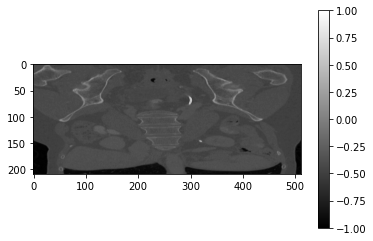

In [11]:
plt.imshow(normalize_negative_one(thick_images_array[:,255,:]),cmap='gray')
plt.colorbar()

The RMSE is: 0.03289661071011808
The PSNR is: 35.67757680274039
The SSIM is: 0.8907012478187691
------------------
The RMSE is: 0.009564230391846527
The PSNR is: 46.407599328306034
The SSIM is: 0.9801599092403364


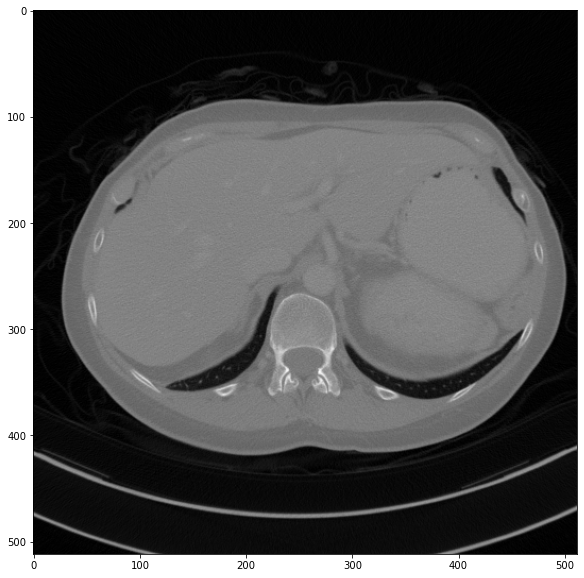

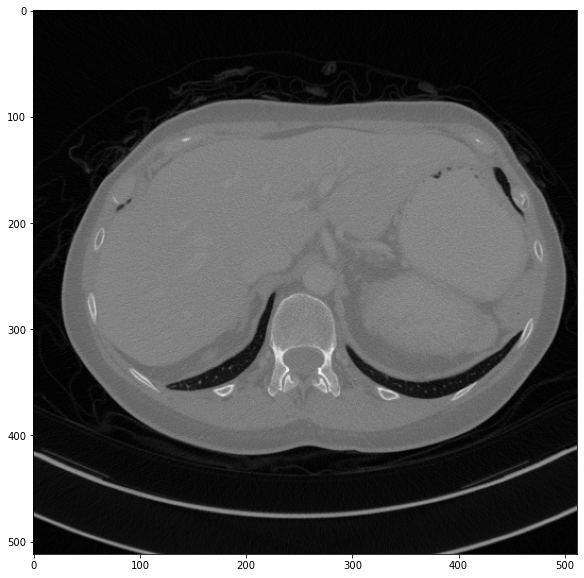

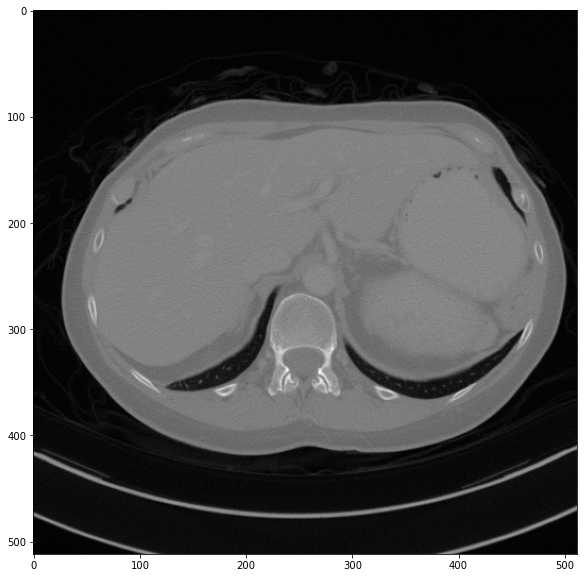

In [14]:
# Axial Plane Comparision
Aplane_idx = 185 #len(thick_images)//2 # range in [0,len(thick_images)]
true_thick = normalize_negative_one(dicom_files[Aplane_idx].pixel_array)

fig1, ax1 = plt.subplots(figsize=(10, 10))
ax1.imshow(true_thick, cmap = 'gray')
#ax1.set_title("True Thick")
#fig1.savefig('./Results_figures/axial_true_thick.png')  # saves the first subplot

fig2, ax2 = plt.subplots(figsize=(10, 10))
ax2.imshow(normalize_negative_one(upsampled_naive_thick[Aplane_idx,:,:].numpy()), cmap = 'gray')
#ax2.set_title("Naive Thick")
#fig2.savefig('./Results_figures/axial_naive_thick.png')  # saves the second subplot

fig3, ax3 = plt.subplots(figsize=(10, 10))
ax3.imshow(normalize_negative_one(thick_images[Aplane_idx].Data), cmap = 'gray')
#ax3.set_title("Simulated Thick")
#fig3.savefig('./Results_figures/axial_simulated_thick.png')  # saves the third subplot

print(f"The RMSE is: {rmse(true_thick,normalize_negative_one(upsampled_naive_thick[Aplane_idx,:,:].numpy()))}")
print(f"The PSNR is: {psnr(true_thick,normalize_negative_one(upsampled_naive_thick[Aplane_idx,:,:].numpy()))}")
print(f"The SSIM is: {ssim(true_thick,normalize_negative_one(upsampled_naive_thick[Aplane_idx,:,:].numpy()))}")
print('------------------')
print(f"The RMSE is: {rmse(true_thick,normalize_negative_one(thick_images[Aplane_idx].Data))}")
print(f"The PSNR is: {psnr(true_thick,normalize_negative_one(thick_images[Aplane_idx].Data))}")
print(f"The SSIM is: {ssim(true_thick,normalize_negative_one(thick_images[Aplane_idx].Data))}")

The RMSE is: 0.025025337095953712
The PSNR is: 38.053001188912596
The SSIM is: 0.9551714157984025
------------------
The RMSE is: 0.005111041398560611
The PSNR is: 51.850411939670416
The SSIM is: 0.9959619171951507


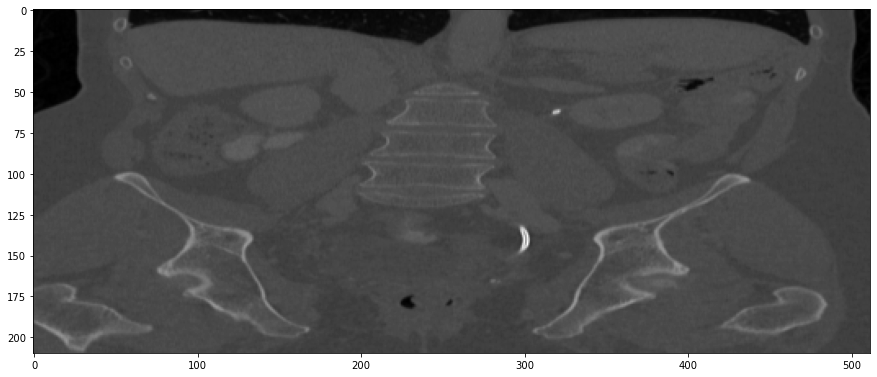

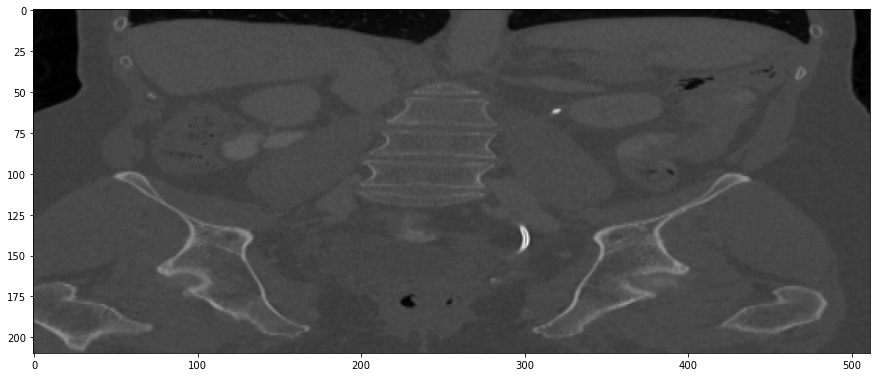

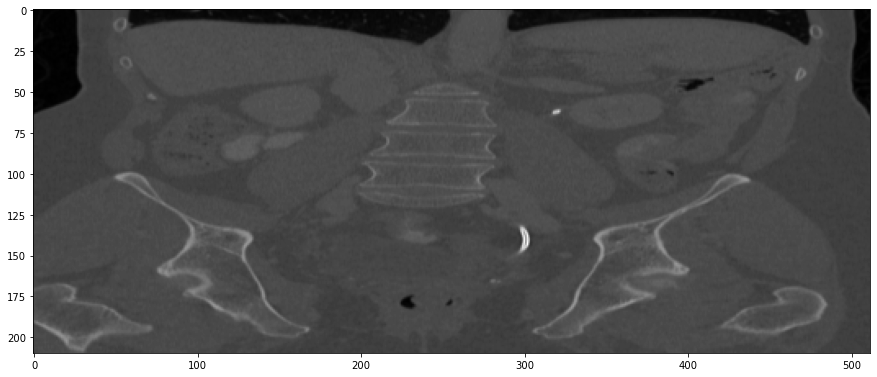

In [15]:
# Coronal Plane Comparison
Cplane_idx = 255 # range in [0,511]
true_thick = np.zeros((len(dicom_files),512))
simulated_thick = np.zeros((len(dicom_files),512))
for i in range(len(thick_images)):
    true_thick[len(thick_images)-i-1,:] = dicom_files[i].pixel_array[Cplane_idx,:]
    simulated_thick[len(thick_images)-i-1,:] = thick_images[i].Data[Cplane_idx,:]
naive_coronal = torch.flip(upsampled_naive_thick[:,Cplane_idx,:],dims=(0,))

true_thick = normalize_negative_one(true_thick)
naive_coronal = normalize_negative_one(naive_coronal.numpy())
simulated_thick = normalize_negative_one(simulated_thick)

fig1, ax1 = plt.subplots(figsize=(15, 15))
ax1.imshow(true_thick,cmap='gray')
#ax1.set_title("True Thick")
fig1.savefig('./Results_figures/coronal_true_thick.png',bbox_inches='tight')  # saves the first subplot

fig2, ax2 = plt.subplots(figsize=(15, 15))
ax2.imshow(naive_coronal,cmap='gray')
#ax2.set_title("Naive Thick")
fig2.savefig('./Results_figures/coronal_naive_thick.png',bbox_inches='tight')

fig3, ax3 = plt.subplots(figsize=(15, 15))
ax3.imshow(simulated_thick,cmap='gray')
#ax3.set_title("Simulated Thick")
fig3.savefig('./Results_figures/coronal_simulated_thick.png',bbox_inches='tight')


print(f"The RMSE is: {rmse(true_thick,naive_coronal)}")
print(f"The PSNR is: {psnr(true_thick,naive_coronal)}")
print(f"The SSIM is: {ssim(true_thick,naive_coronal)}")
print('------------------')
print(f"The RMSE is: {rmse(true_thick,simulated_thick)}")
print(f"The PSNR is: {psnr(true_thick,simulated_thick)}")
print(f"The SSIM is: {ssim(true_thick,simulated_thick)}")

The RMSE is: 0.035655338029837814
The PSNR is: 34.97810875078013
The SSIM is: 0.9075672935423997
------------------
The RMSE is: 0.00695282338551267
The PSNR is: 49.1773759603191
The SSIM is: 0.9939219739297042


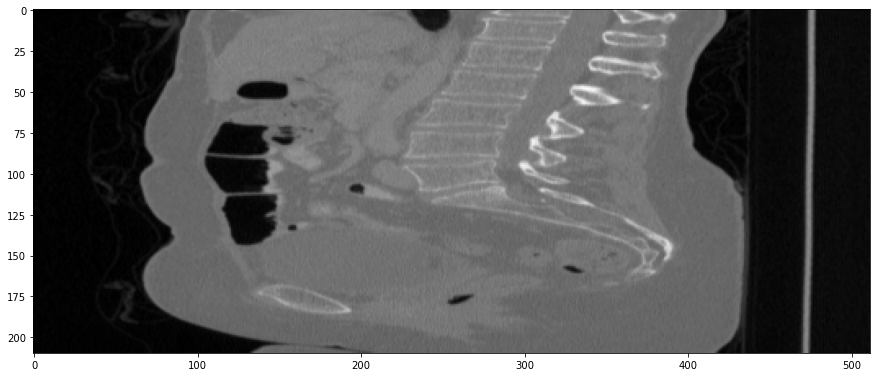

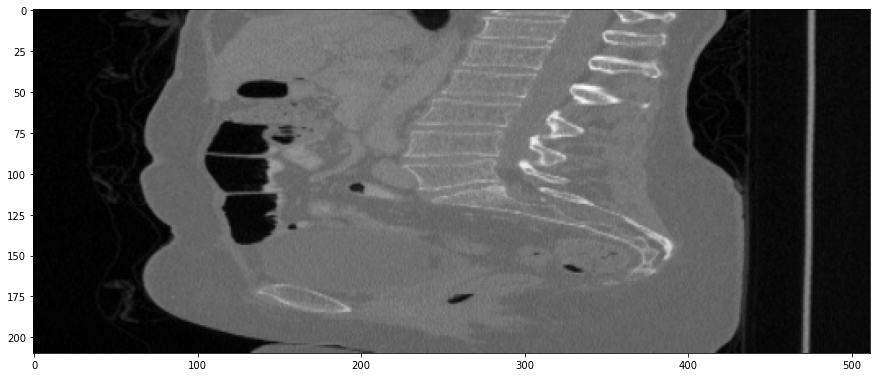

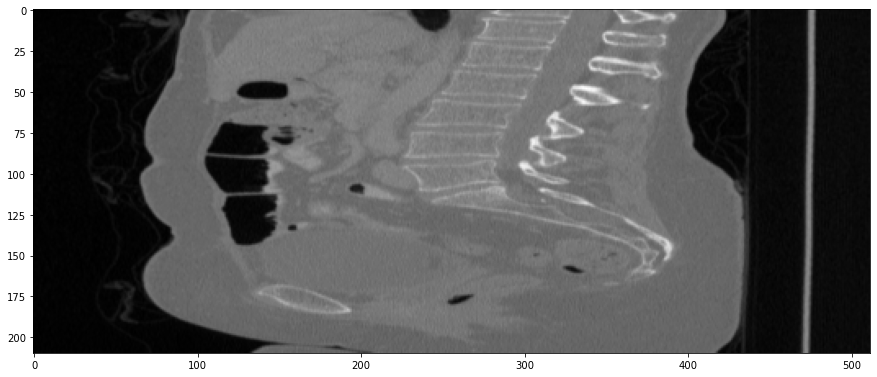

In [16]:
# Sagittal Plane Comparision
Splane_idx = 255 # range in [0,511]
true_thick = np.zeros((len(dicom_files),512)) 
simulated_thick = np.zeros((len(dicom_files),512)) 
for i in range(len(thick_images)):
    true_thick[len(thick_images)-i-1,:] = dicom_files[i].pixel_array[:,Splane_idx]
    simulated_thick[len(thick_images)-i-1,:] = thick_images[i].Data[:,Splane_idx]
naive_sagittal = torch.flip(upsampled_naive_thick[:,:,Splane_idx],dims=(0,))

true_thick = normalize_negative_one(true_thick)
naive_sagittal = normalize_negative_one(naive_sagittal.numpy())
simulated_thick = normalize_negative_one(simulated_thick)

fig1, ax1 = plt.subplots(figsize=(15, 15))
ax1.imshow(true_thick,cmap='gray')
#ax1.set_title("True Thick")
fig1.savefig('./Results_figures/sagittal_true_thick.png',bbox_inches='tight')

fig2, ax2 = plt.subplots(figsize=(15, 15))
ax2.imshow(naive_sagittal,cmap='gray')
#ax2.set_title("Naive Thick")
fig2.savefig('./Results_figures/sagittal_naive_thick.png',bbox_inches='tight')

fig3, ax3 = plt.subplots(figsize=(15, 15))
ax3.imshow(simulated_thick,cmap='gray')
#ax3.set_title("Simulated Thick")
fig3.savefig('./Results_figures/sagittal_simulated_thick.png',bbox_inches='tight')

print(f"The RMSE is: {rmse(true_thick,naive_sagittal)}")
print(f"The PSNR is: {psnr(true_thick,naive_sagittal)}")
print(f"The SSIM is: {ssim(true_thick,naive_sagittal)}")
print('------------------')
print(f"The RMSE is: {rmse(true_thick,simulated_thick)}")
print(f"The PSNR is: {psnr(true_thick,simulated_thick)}")
print(f"The SSIM is: {ssim(true_thick,simulated_thick)}")

In [ ]:
% Downsample
% axial
% The RMSE is: 0.04540983143758717
% The PSNR is: 32.87760211743674
% The SSIM is: 0.7823772484545244
% coronal
% ------------------
% The RMSE is: 0.03487728892424276
% The PSNR is: 35.16974553199171
% The SSIM is: 0.9149201993040073
% sagittal
% ------------------
% The RMSE is: 0.0486097553960034
% The PSNR is: 32.286131199023195
% The SSIM is: 0.8500904424432553


% Gaussian
% axial
% The RMSE is: 0.09548193462170887
% The PSNR is: 26.42217571433124
% The SSIM is: 0.5331679545853734
% coronal
% ------------------
% The RMSE is: 0.17584114164585718
% The PSNR is: 21.11819001850586
% The SSIM is: 0.7763000670789398
% sagittal
% ------------------
% The RMSE is: 0.04536282795099552
% The PSNR is: 32.88659749415874
% The SSIM is: 0.8039841121515602

% Naive
% axial
% The RMSE is: 0.03289661071011808
% The PSNR is: 35.67757680274039
% The SSIM is: 0.8907012478187691
% coronal
% ------------------
% The RMSE is: 0.025025337095953712
% The PSNR is: 38.053001188912596
% The SSIM is: 0.9551714157984025
% sagittal
% ------------------
% The RMSE is: 0.035655338029837814
% The PSNR is: 34.97810875078013
% The SSIM is: 0.9075672935423997

% OurTS
% axial
% The RMSE is: 0.009564230391846527
% The PSNR is: 46.407599328306034
% The SSIM is: 0.9801599092403364
% coronal
% ------------------
% The RMSE is: 0.005111041398560611
% The PSNR is: 51.850411939670416
% The SSIM is: 0.9959619171951507
% sagittal
% ------------------
% The RMSE is: 0.00695282338551267
% The PSNR is: 49.1773759603191
% The SSIM is: 0.9939219739297042